# Gradient Boosted Regression Tree (GBRT)
### Using XGBoost Regressor

In [687]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

# Set plot style
plt.style.use('ggplot')

In [688]:
data = pd.read_csv("data/linked_data.csv")

### Define Random Search for Hyperparameter Tuning

In [689]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data,
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error'):
    gs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            cv=cv,
            n_jobs=-1,
            scoring=scoring_fit,
            verbose=2,
            n_iter=100,
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    pred = fitted_model.predict(X_test_data)

    return fitted_model, pred

In [690]:
# Parameters for random search
param_grid = {'max_depth': sp_randInt(3,20),
              'learning_rate': sp_randFloat(),
              'subsample': sp_randFloat(),
              'colsample_bytree': sp_randFloat(),
              'colsample_bylevel': sp_randFloat(),
              'n_estimators': sp_randInt(100,1000)}

### Univariable XGBoost Regressor

In [691]:
x = data.loc[:, 'log_weighted_avg']
x2 = data.loc[:, 'log_gc_per_day']
y = data.loc[:, 'avg_r_avg']

In [692]:
# Split 80% data for training and 20% for test, following Morvan et. al (function default 25% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

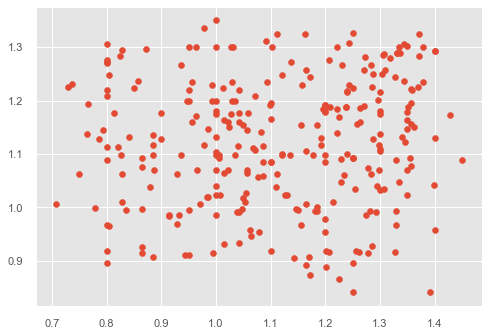

In [693]:
# Initial 'plain' model: univariable model without tuning
xgbr = XGBRegressor()
plain_fit = xgbr.fit(x_train, y_train)
plain_pred = plain_fit.predict(x_test)

# Scatter plot of actual and predicted values
plt.scatter(y_test, plain_pred)

In [694]:
# RMSE
plain_rmse = np.sqrt(mean_squared_error(y_test, plain_pred))

In [695]:
# Univariable model with tuning
uni_model, uni_pred = algorithm_pipeline(x_train, x_test, y_train, xgbr, param_grid, cv=10)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [696]:
# Best parameters
uni_model.best_params_

{'colsample_bylevel': 0.5508815791489519,
 'colsample_bytree': 0.5491794902664856,
 'learning_rate': 0.0036209694767929124,
 'max_depth': 8,
 'n_estimators': 990,
 'subsample': 0.3554149730605638}

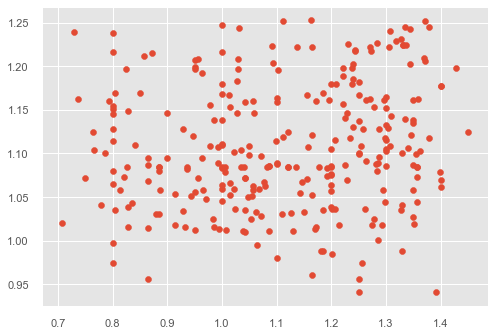

In [697]:
# Scatter plot of actual and predicted values
plt.scatter(y_test, uni_pred)

In [698]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, uni_pred))

<AxesSubplot:title={'center':'Residuals for RandomizedSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

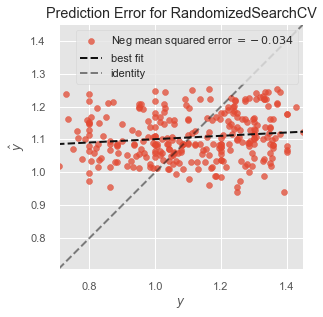

<Figure size 576x396 with 0 Axes>

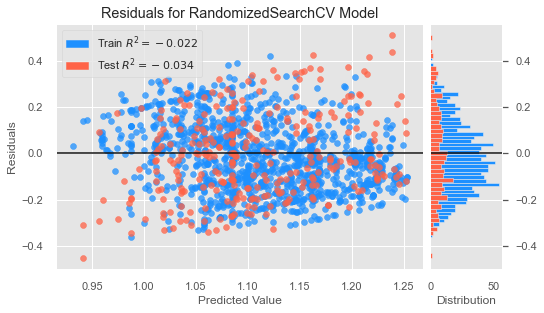

In [699]:
# Making the Prediction Error Plot
visualiser1 = PredictionError(uni_model,
                              fig=plt.figure(figsize=(8, 4.5))
                              )
visualiser1.fit(x_train, y_train)
visualiser1.score(x_test, y_test)
visualiser1.show(outpath="Prediction Error Plot (Uni).png")

# Making the Residuals Plot
plt.figure()
visualiser2 = ResidualsPlot(uni_model,
                            train_color="dodgerblue",
                            test_color="tomato",
                            fig=plt.figure(figsize=(8,4.5))
                            )

visualiser2.fit(x_train, y_train)
visualiser2.score(x_test, y_test)
visualiser2.show(outpath="Residuals Plot (Uni).png")

### Multivaribale regression model

In [700]:
X = data[['log_weighted_avg', 'log_suspended_solids', 'log_ammonia', 'log_ophosph','sample_ph_weighted', 'raw_ansis_sars_repc_std_weighted', 'compo_frac_weighted', 'sars_below_lod_weighted', 'reception_delay_weighted', 'regional_popn']]

In [701]:
# Lower and upper bounds
ylow = data.loc[:, 'avg_r_lower']
yup = data.loc[:, 'avg_r_upper']

In [702]:
# avg R
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# lower bound R
Xlow_train, Xlow_test, Ylow_train, Ylow_test = train_test_split(X, ylow, test_size=0.2, random_state=42)

# upper bound R
Xup_train, Xup_test, Yup_train, Yup_test = train_test_split(X, yup, test_size=0.2, random_state=42)

In [703]:
# Build model for avg R
multi_model, multi_pred = algorithm_pipeline(X_train, X_test, Y_train, xgbr, param_grid, cv=10)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [704]:
# Show best hyperparameters
multi_model.best_params_

{'colsample_bylevel': 0.22863113690908388,
 'colsample_bytree': 0.7548128927664769,
 'learning_rate': 0.07280859993879774,
 'max_depth': 12,
 'n_estimators': 870,
 'subsample': 0.8188239513830387}

<AxesSubplot:title={'center':'Prediction Error for RandomizedSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

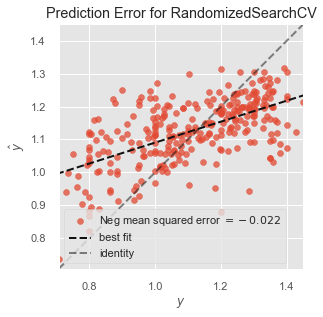

In [705]:
# Making the Prediction Error Plot
visualiser1 = PredictionError(multi_model,
                              fig=plt.figure(figsize=(8, 4.5))
                              )
visualiser1.fit(X_train, Y_train)
visualiser1.score(X_test, Y_test)
visualiser1.show(outpath="Prediction Error Plot.png")

<AxesSubplot:title={'center':'Residuals for RandomizedSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

<Figure size 576x396 with 0 Axes>

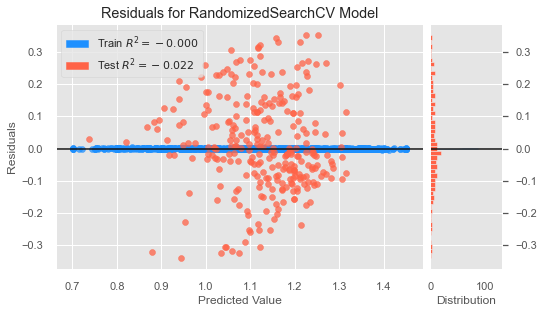

In [706]:
# Making the Residuals Plot
plt.figure()
visualiser2 = ResidualsPlot(multi_model,
                             train_color="dodgerblue",
                             test_color="tomato",
                             fig=plt.figure(figsize=(8,4.5))
                             )

visualiser2.fit(X_train, Y_train)
visualiser2.score(X_test, Y_test)
visualiser2.show(outpath="Residuals Plot.png")

In [707]:
multi_rmse = np.sqrt(mean_squared_error(Y_test, multi_pred))

In [708]:
multi_model_low, multi_pred_low = algorithm_pipeline(Xlow_train, Xlow_test, Ylow_train, xgbr, param_grid, cv=10)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END colsample_bylevel=0.44190974086216184, colsample_bytree=0.8439400250851652, learning_rate=0.594492322580589, max_depth=3, n_estimators=262, subsample=0.06856080200125902; total time=   0.1s
[CV] END colsample_bylevel=0.4172569314659018, colsample_bytree=0.181313096002241, learning_rate=0.620655820430038, max_depth=18, n_estimators=607, subsample=0.907253223638992; total time=   0.5s
[CV] END colsample_bylevel=0.4172569314659018, colsample_bytree=0.181313096002241, learning_rate=0.620655820430038, max_depth=18, n_estimators=607, subsample=0.907253223638992; total time=   0.5s
[CV] END colsample_bylevel=0.3938665849470504, colsample_bytree=0.2962794593485203, learning_rate=0.5280172692975947, max_depth=12, n_estimators=869, subsample=0.923064456537224; total time=   0.6s
[CV] END colsample_bylevel=0.012641283774658785, colsample_bytree=0.4833603928563788, learning_rate=0.10530399213867137, max_depth=3, n_estimators

In [709]:
multi_rmse_low = np.sqrt(mean_squared_error(Ylow_test, multi_pred_low))

In [710]:
multi_model_up, multi_pred_up = algorithm_pipeline(Xup_train, Xup_test, Yup_train, xgbr, param_grid, cv=10)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END colsample_bylevel=0.44190974086216184, colsample_bytree=0.8439400250851652, learning_rate=0.594492322580589, max_depth=3, n_estimators=262, subsample=0.06856080200125902; total time=   0.1s
[CV] END colsample_bylevel=0.4172569314659018, colsample_bytree=0.181313096002241, learning_rate=0.620655820430038, max_depth=18, n_estimators=607, subsample=0.907253223638992; total time=   0.5s
[CV] END colsample_bylevel=0.13972695300937055, colsample_bytree=0.9969448244241037, learning_rate=0.018169396048480335, max_depth=14, n_estimators=246, subsample=0.7512655283209417; total time=   0.2s
[CV] END colsample_bylevel=0.13972695300937055, colsample_bytree=0.9969448244241037, learning_rate=0.018169396048480335, max_depth=14, n_estimators=246, subsample=0.7512655283209417; total time=   0.3s
[CV] END colsample_bylevel=0.3938665849470504, colsample_bytree=0.2962794593485203, learning_rate=0.5280172692975947, max_depth=12, n_es

In [711]:
multi_rmse_up = np.sqrt(mean_squared_error(Yup_test, multi_pred_up))

### RMSE Plot

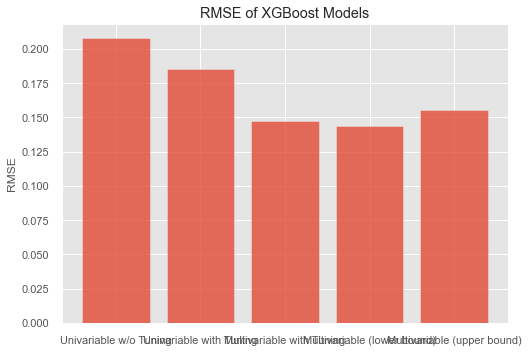

In [712]:
objects = ('Univariable w/o Tuning', 'Univariable with Tuning', 'Multivariable with Tuning', 'Multivariable (lower bound)', 'Multivariable (upper bound)')
y_pos = np.arange(len(objects))
performance = [plain_rmse, rmse, multi_rmse, multi_rmse_low, multi_rmse_up]

gx = plt.bar(y_pos, performance, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.title('RMSE of XGBoost Models')

plt.savefig('RMSE Plot.png')

### Partial Dependence Plot

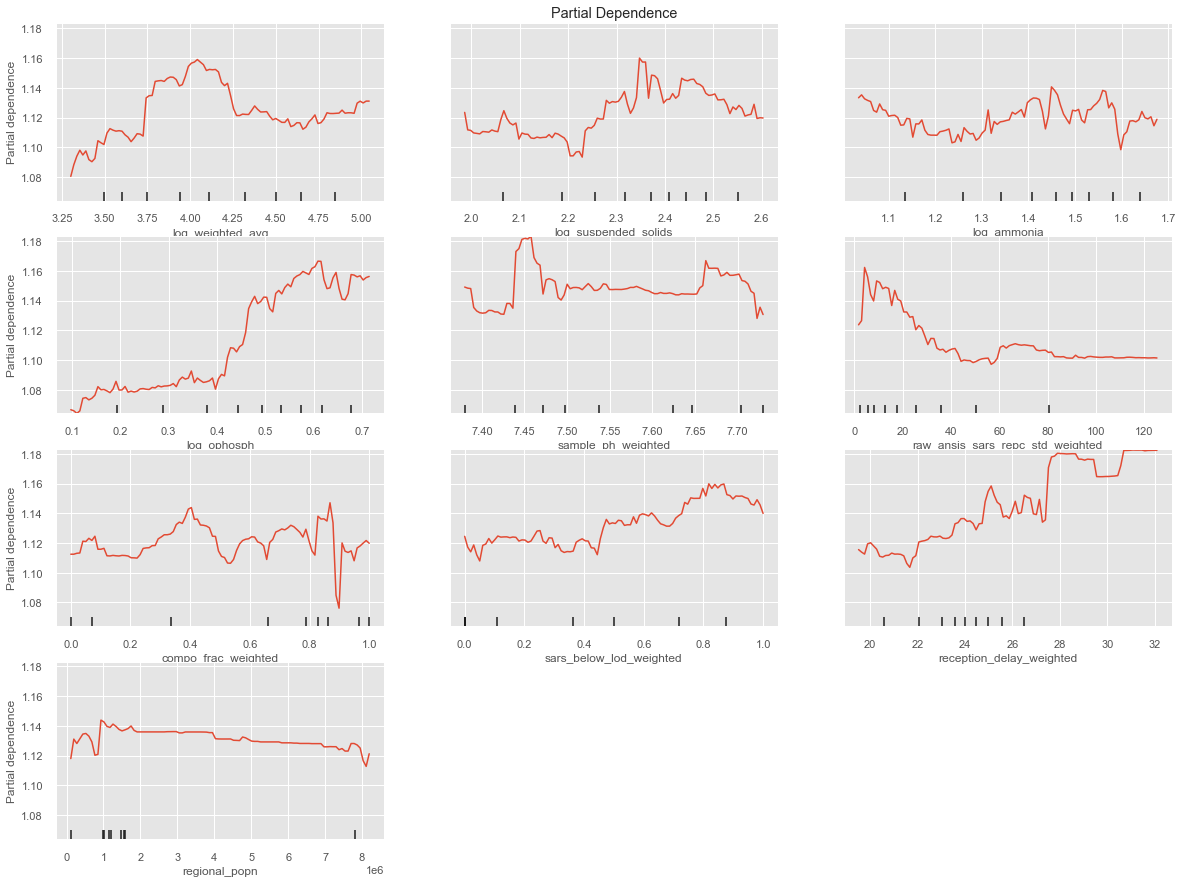

In [713]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(20, 15))
ax.set_title("Partial Dependence")
disp = PartialDependenceDisplay.from_estimator(multi_model, X, ['log_weighted_avg', 'log_suspended_solids', 'log_ammonia', 'log_ophosph', 'sample_ph_weighted', 'raw_ansis_sars_repc_std_weighted', 'compo_frac_weighted', 'sars_below_lod_weighted', 'reception_delay_weighted', 'regional_popn'], ax=ax)

plt.savefig('PDP.png')